In [9]:
import os
import numpy as np
import nibabel as nib
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tqdm import tqdm


In [10]:
# Paths and parameters
DATASET_DIR = 'BraTS2020_TrainingData'
MODALITIES = ['flair', 't1', 't1ce', 't2']
LABEL_MAPPING = {0: 0, 1: 1, 2: 2, 4: 3}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [ ]:
import random  # Make sure this is imported

class BraTSDataset(Dataset):
    def __init__(self, patient_dirs, augment=False):
        self.patient_dirs = patient_dirs
        self.augment = augment  # Flag for data augmentation

    def __len__(self):
        return len(self.patient_dirs)

    def __getitem__(self, idx):
        patient_path = self.patient_dirs[idx]
        modalities = []

        for mod in MODALITIES:
            img_path = os.path.join(patient_path, f"{os.path.basename(patient_path)}_{mod}.nii")
            img = nib.load(img_path).get_fdata()
            modalities.append(img)

        image = np.stack(modalities, axis=0).astype(np.float32)  # [4, H, W, D]
        seg_path = os.path.join(patient_path, f"{os.path.basename(patient_path)}_seg.nii")
        mask = nib.load(seg_path).get_fdata().astype(np.uint8)

        # Take mid-slice
        mid_slice = image.shape[3] // 2
        image_slice = image[:, :, :, mid_slice]   # [4, H, W]
        mask_slice = mask[:, :, mid_slice]        # [H, W]

        # Normalize per channel (modality)
        for i in range(image_slice.shape[0]):
            mean = image_slice[i].mean()
            std = image_slice[i].std()
            if std > 0:
                image_slice[i] = (image_slice[i] - mean) / std

        # Label remapping (from {0, 1, 2, 4} → {0, 1, 2, 3})
        mask_slice = np.vectorize(LABEL_MAPPING.get)(mask_slice)

        #Data Augmentation
        if self.augment:
            if random.random() > 0.5:
                image_slice = np.flip(image_slice, axis=1).copy()  # Vertical flip
                mask_slice = np.flip(mask_slice, axis=0).copy()
            if random.random() > 0.5:
                image_slice = np.flip(image_slice, axis=2).copy()  # Horizontal flip
                mask_slice = np.flip(mask_slice, axis=1).copy()

        return torch.tensor(image_slice, dtype=torch.float32), torch.tensor(mask_slice, dtype=torch.long)


In [12]:
all_patients = [os.path.join(DATASET_DIR, p) for p in os.listdir(DATASET_DIR) if os.path.isdir(os.path.join(DATASET_DIR, p))]
train_patients, val_patients = train_test_split(all_patients, test_size=0.2, random_state=42)

train_dataset = BraTSDataset(train_patients, augment=True)
val_dataset = BraTSDataset(val_patients, augment=False)


train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=2)


In [13]:
class UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=4):
        super(UNet, self).__init__()

        def conv_block(in_c, out_c):
            return nn.Sequential(
                nn.Conv2d(in_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_c, out_c, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
            )

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)

        self.pool = nn.MaxPool2d(2)

        self.up2 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.up1 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))

        d2 = self.up2(e3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.up1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return self.final(d1)


In [14]:
def train_one_epoch(model, loader, optimizer, criterion):
    model.train()
    running_loss = 0.0
    for img, mask in tqdm(loader):
        img, mask = img.to(device), mask.to(device)
        optimizer.zero_grad()
        out = model(img)
        loss = criterion(out, mask)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(loader)

def evaluate(model, loader, criterion):
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for img, mask in loader:
            img, mask = img.to(device), mask.to(device)
            out = model(img)
            loss = criterion(out, mask)
            val_loss += loss.item()
    return val_loss / len(loader)


In [15]:
model = UNet().to(device)
weights = torch.tensor([0.05, 1.0, 1.0, 1.2], device=device)  # Background, Necrosis, Edema, Enhancing
criterion = nn.CrossEntropyLoss(weight=weights)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

num_epochs = 50
for epoch in range(num_epochs):
    train_loss = train_one_epoch(model, train_loader, optimizer, criterion)
    val_loss = evaluate(model, val_loader, criterion)
    print(f"Epoch {epoch+1}: Train Loss = {train_loss:.4f}, Val Loss = {val_loss:.4f}")


100%|██████████| 12/12 [00:51<00:00,  4.32s/it]


Epoch 1: Train Loss = 1.0104, Val Loss = 0.6443


100%|██████████| 12/12 [00:41<00:00,  3.44s/it]


Epoch 2: Train Loss = 0.5267, Val Loss = 0.5724


100%|██████████| 12/12 [00:40<00:00,  3.41s/it]


Epoch 3: Train Loss = 0.3695, Val Loss = 0.4063


100%|██████████| 12/12 [00:39<00:00,  3.31s/it]


Epoch 4: Train Loss = 0.3571, Val Loss = 0.3894


100%|██████████| 12/12 [00:42<00:00,  3.52s/it]


Epoch 5: Train Loss = 0.2800, Val Loss = 0.3983


100%|██████████| 12/12 [00:41<00:00,  3.50s/it]


Epoch 6: Train Loss = 0.2729, Val Loss = 0.3603


100%|██████████| 12/12 [00:35<00:00,  2.94s/it]


Epoch 7: Train Loss = 0.2636, Val Loss = 0.3796


100%|██████████| 12/12 [00:32<00:00,  2.68s/it]


Epoch 8: Train Loss = 0.2394, Val Loss = 0.3775


100%|██████████| 12/12 [00:30<00:00,  2.51s/it]


Epoch 9: Train Loss = 0.2447, Val Loss = 0.3429


100%|██████████| 12/12 [00:29<00:00,  2.46s/it]


Epoch 10: Train Loss = 0.2099, Val Loss = 0.3448


100%|██████████| 12/12 [00:28<00:00,  2.38s/it]


Epoch 11: Train Loss = 0.1788, Val Loss = 0.3766


100%|██████████| 12/12 [00:28<00:00,  2.37s/it]


Epoch 12: Train Loss = 0.1612, Val Loss = 0.3248


100%|██████████| 12/12 [00:27<00:00,  2.27s/it]


Epoch 13: Train Loss = 0.1414, Val Loss = 0.3573


100%|██████████| 12/12 [00:29<00:00,  2.46s/it]


Epoch 14: Train Loss = 0.1466, Val Loss = 0.3601


100%|██████████| 12/12 [00:29<00:00,  2.44s/it]


Epoch 15: Train Loss = 0.1676, Val Loss = 0.3511


100%|██████████| 12/12 [00:28<00:00,  2.35s/it]


Epoch 16: Train Loss = 0.1771, Val Loss = 0.4875


100%|██████████| 12/12 [00:29<00:00,  2.50s/it]


Epoch 17: Train Loss = 0.1672, Val Loss = 0.2740


100%|██████████| 12/12 [00:28<00:00,  2.38s/it]


Epoch 18: Train Loss = 0.1701, Val Loss = 0.2943


100%|██████████| 12/12 [00:27<00:00,  2.30s/it]


Epoch 19: Train Loss = 0.1413, Val Loss = 0.3744


100%|██████████| 12/12 [00:28<00:00,  2.40s/it]


Epoch 20: Train Loss = 0.1454, Val Loss = 0.3185


100%|██████████| 12/12 [00:33<00:00,  2.80s/it]


Epoch 21: Train Loss = 0.1392, Val Loss = 0.4057


100%|██████████| 12/12 [00:31<00:00,  2.60s/it]


Epoch 22: Train Loss = 0.1489, Val Loss = 0.3734


100%|██████████| 12/12 [00:31<00:00,  2.63s/it]


Epoch 23: Train Loss = 0.1262, Val Loss = 0.2916


100%|██████████| 12/12 [00:30<00:00,  2.53s/it]


Epoch 24: Train Loss = 0.1344, Val Loss = 0.2828


100%|██████████| 12/12 [00:23<00:00,  1.94s/it]


Epoch 25: Train Loss = 0.1414, Val Loss = 0.3442


100%|██████████| 12/12 [00:23<00:00,  1.97s/it]


Epoch 26: Train Loss = 0.1232, Val Loss = 0.2953


100%|██████████| 12/12 [00:23<00:00,  1.93s/it]


Epoch 27: Train Loss = 0.1181, Val Loss = 0.2802


100%|██████████| 12/12 [00:23<00:00,  1.92s/it]


Epoch 28: Train Loss = 0.1334, Val Loss = 0.3281


100%|██████████| 12/12 [00:23<00:00,  1.92s/it]


Epoch 29: Train Loss = 0.1344, Val Loss = 0.2788


100%|██████████| 12/12 [00:23<00:00,  1.92s/it]


Epoch 30: Train Loss = 0.1268, Val Loss = 0.3071


100%|██████████| 12/12 [00:23<00:00,  1.93s/it]


Epoch 31: Train Loss = 0.1505, Val Loss = 0.3257


100%|██████████| 12/12 [00:22<00:00,  1.91s/it]


Epoch 32: Train Loss = 0.1549, Val Loss = 0.4476


100%|██████████| 12/12 [00:23<00:00,  1.92s/it]


Epoch 33: Train Loss = 0.1435, Val Loss = 0.2975


100%|██████████| 12/12 [00:23<00:00,  1.98s/it]


Epoch 34: Train Loss = 0.1233, Val Loss = 0.2548


100%|██████████| 12/12 [00:24<00:00,  2.05s/it]


Epoch 35: Train Loss = 0.1237, Val Loss = 0.2617


100%|██████████| 12/12 [00:23<00:00,  1.99s/it]


Epoch 36: Train Loss = 0.1333, Val Loss = 0.2714


100%|██████████| 12/12 [00:23<00:00,  1.97s/it]


Epoch 37: Train Loss = 0.1314, Val Loss = 0.2629


100%|██████████| 12/12 [00:23<00:00,  1.98s/it]


Epoch 38: Train Loss = 0.1224, Val Loss = 0.2854


100%|██████████| 12/12 [00:23<00:00,  1.99s/it]


Epoch 39: Train Loss = 0.1282, Val Loss = 0.3859


100%|██████████| 12/12 [00:24<00:00,  2.01s/it]


Epoch 40: Train Loss = 0.1241, Val Loss = 0.2891


100%|██████████| 12/12 [00:23<00:00,  1.98s/it]


Epoch 41: Train Loss = 0.1104, Val Loss = 0.2403


100%|██████████| 12/12 [00:23<00:00,  1.99s/it]


Epoch 42: Train Loss = 0.1064, Val Loss = 0.2528


100%|██████████| 12/12 [00:23<00:00,  1.99s/it]


Epoch 43: Train Loss = 0.1082, Val Loss = 0.2988


100%|██████████| 12/12 [00:24<00:00,  2.01s/it]


Epoch 44: Train Loss = 0.1176, Val Loss = 0.3356


100%|██████████| 12/12 [00:23<00:00,  1.99s/it]


Epoch 45: Train Loss = 0.1084, Val Loss = 0.2941


100%|██████████| 12/12 [00:24<00:00,  2.00s/it]


Epoch 46: Train Loss = 0.0973, Val Loss = 0.3640


100%|██████████| 12/12 [00:24<00:00,  2.00s/it]


Epoch 47: Train Loss = 0.0958, Val Loss = 0.2630


100%|██████████| 12/12 [00:24<00:00,  2.03s/it]


Epoch 48: Train Loss = 0.0959, Val Loss = 0.2614


100%|██████████| 12/12 [00:24<00:00,  2.02s/it]


Epoch 49: Train Loss = 0.1006, Val Loss = 0.2858


100%|██████████| 12/12 [00:24<00:00,  2.02s/it]


Epoch 50: Train Loss = 0.1070, Val Loss = 0.2716


In [16]:
def visualize_prediction(model, dataset, index=0):
    model.eval()
    img, mask = dataset[index]
    img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(img).argmax(1).squeeze().cpu().numpy()

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img[0, 0].cpu(), cmap='gray')
    axs[0].set_title("FLAIR Image")
    axs[1].imshow(mask.cpu(), cmap='jet')
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred, cmap='jet')
    axs[2].set_title("Predicted Mask")
    plt.tight_layout()
    plt.show()


In [20]:
pred = torch.argmax(output, dim=1).squeeze(0).cpu()
print("Predicted mask labels:", torch.unique(pred))


Predicted mask labels: tensor([0, 2])


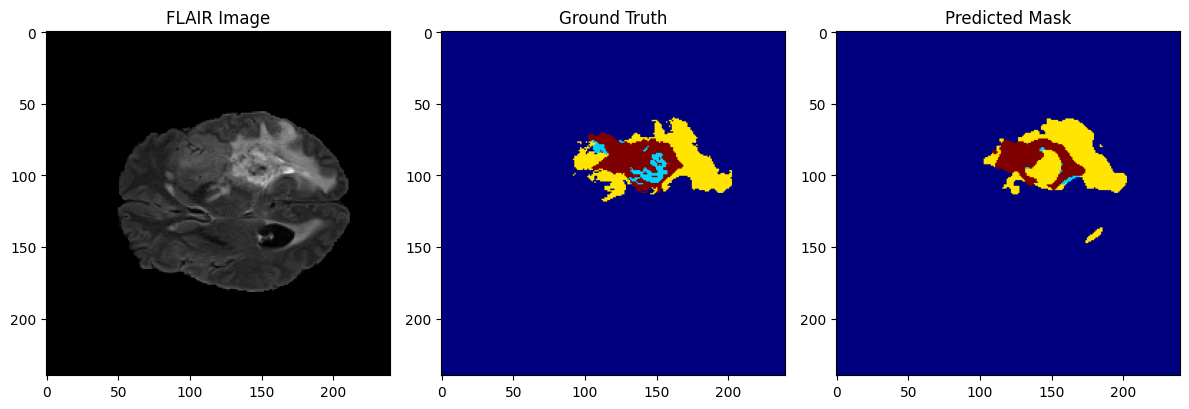

In [21]:
visualize_prediction(model, val_dataset, index=4)


In [18]:
img, mask = val_dataset[2]
print("Unique labels in mask:", torch.unique(mask))


Unique labels in mask: tensor([0, 1, 2, 3])


In [19]:
model.eval()
img, mask = val_dataset[0]
img = img.unsqueeze(0).to(device)

with torch.no_grad():
    output = model(img)
    pred = output.argmax(1).squeeze().cpu()
    print("Unique labels in prediction:", torch.unique(pred))


Unique labels in prediction: tensor([0, 2])


In [22]:
def visualize_prediction(model, dataset, index=0):
    model.eval()
    img, mask = dataset[index]
    img = img.unsqueeze(0).to(device)

    with torch.no_grad():
        pred = model(img).argmax(1).squeeze().cpu().numpy()

    mask = mask.numpy()

    # Custom color map
    from matplotlib.colors import ListedColormap
    tumor_cmap = ListedColormap(['black', 'red', 'green', 'yellow'])  # 0=bg, 1,2,3

    fig, axs = plt.subplots(1, 3, figsize=(12, 4))
    axs[0].imshow(img[0, 0].cpu(), cmap='gray')
    axs[0].set_title("FLAIR Image")
    axs[1].imshow(mask, cmap=tumor_cmap, vmin=0, vmax=3)
    axs[1].set_title("Ground Truth")
    axs[2].imshow(pred, cmap=tumor_cmap, vmin=0, vmax=3)
    axs[2].set_title("Predicted Mask")
    plt.tight_layout()
    plt.show()


In [23]:
import torch
import matplotlib.pyplot as plt

# Pick a validation sample
img, mask = val_dataset[3]  # Change index if needed

# Move image to device and add batch dimension
img_input = img.unsqueeze(0).to(device)

# Disable gradient for inference
model.eval()
with torch.no_grad():
    output = model(img_input)  # shape: (1, num_classes, H, W)
    pred = torch.argmax(output, dim=1).squeeze(0).cpu()  # (H, W)

# Print unique labels in prediction and GT
print("Predicted mask labels:", torch.unique(pred))
print("Ground truth labels:", torch.unique(mask))

# Evaluation
metrics = compute_metrics(pred, mask.cpu(), num_classes=4)

# Display metrics
labels = ["Background", "Necrosis", "Edema", "Enhancing Tumor"]
for i, (dice, iou) in enumerate(zip(metrics['Dice'], metrics['IoU'])):
    print(f"{labels[i]}: Dice = {dice:.4f}, IoU = {iou:.4f}")
print(f"Pixel Accuracy: {metrics['Pixel Accuracy']:.4f}")


Predicted mask labels: tensor([0, 2, 3])
Ground truth labels: tensor([0, 2, 3])
Background: Dice = 0.9937, IoU = 0.9875
Necrosis: Dice = 1.0000, IoU = 1.0000
Edema: Dice = 0.8279, IoU = 0.7064
Enhancing Tumor: Dice = 0.0488, IoU = 0.0250
Pixel Accuracy: 0.9876


In [ ]:
outputs = model(img.unsqueeze(0).to(device))  
predicted_mask = outputs.argmax(dim=1).squeeze(0).cpu()


In [25]:
ground_truth_mask = mask.cpu()

metrics = compute_metrics(predicted_mask, ground_truth_mask)

labels = ["Background", "Necrosis", "Edema", "Enhancing Tumor"]
for i, (dice, iou) in enumerate(zip(metrics['Dice'], metrics['IoU'])):
    print(f"{labels[i]}: Dice = {dice:.4f}, IoU = {iou:.4f}")

print(f"Pixel-wise Accuracy: {metrics['Pixel Accuracy']:.4f}")


Background: Dice = 0.9937, IoU = 0.9875
Necrosis: Dice = 1.0000, IoU = 1.0000
Edema: Dice = 0.8279, IoU = 0.7064
Enhancing Tumor: Dice = 0.0488, IoU = 0.0250
Pixel-wise Accuracy: 0.9876
